# Theory Approximations
This runs through derivation of theory, to gain two exact equations for $\delta \Delta h^{\dagger}$, one from free troposphere and surface. In the derivation, I quantify approximations I make using different $A$ values.

It also allows you to specify the reference day that the theory is built around, indicated by the tilde.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/2 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_exp = [default_colors[0], default_colors[1]]
ax_linewidth = plt.rcParams['axes.linewidth']


labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

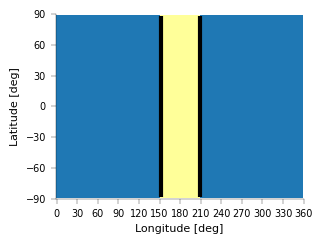

In [4]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [5]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
lat = ds[0].lat[lat_use_ind].to_numpy()

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
# Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        z_av['median'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean'][j] = rh_use.mean(dim='lon_time')
        r_av['median'][j] = rh_use.median(dim='lon_time')
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)

  0%|          | 0/2772 [00:00<?, ?it/s]

In [7]:
# Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
# In units of kJ/kg
epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0) -
                 moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))
epsilon_av = {}
for key in ['mean', 'median']:
    epsilon_av[key] = (moist_static_energy(temp_av[key][:, ind_surf], r_av[key] * sphum_sat(temp_av[key][:, ind_surf], p_surface), height=0) -
                       moist_static_energy(temp_av[key][:, ind_ft], sphum_sat(temp_av[key][:, ind_ft], pressure_ft_actual), z_av[key][:, ind_ft]))

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$ and CAPE proxy, $\tilde{\epsilon}$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$h^{\dagger} = (c_p - R^{\dagger})T_s + L_v q_s - \epsilon \approx (c_p + R^{\dagger})T_{FT} + L_vq^*(T_{FT}, p_{FT})$

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$

where the overline refers to the time-zonal mean value of that quantity.

In [36]:
av_use = 'mean'
r_ref = np.zeros((n_kappa, n_lat))
r_ref[:] = r_av[av_use][0]        # no change in rh with warming, assumed for ref
# r_ref[:] = r_av[av_use]
epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation
# epsilon_ref[:] = epsilon_av[av_use]
temp_ref = np.zeros((n_kappa, n_pressure, n_lat))
temp_ref[:, ind_surf] = temp_av[av_use][:, ind_surf]  # Have actual average surface temperature change with warming
sphum_ref = r_ref * sphum_sat(temp_ref[:, ind_surf], p_surface)

# Given reference T_s, RH and epsilon, T_FT directly from the modified MSE equation.
# This means that there is no approximation associated with geopotential height for the reference day
for i in range(n_kappa):
    for j in range(n_lat):
        temp_ref[i, ind_ft, j] = get_temp_adiabat(temp_ref[i, ind_surf, j], sphum_ref[i, j],
                                                    p_surface, pressure_ft_actual, epsilon=epsilon_ref[i, j])

In [37]:
# Plot showing how reference values differs from average
show_plot = False
av_plot = av_use
fig, ax = plt.subplots(1,4, figsize=(4*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(lat, temp_av[av_plot][i, ind_surf], color=color_exp[i], label=labels_exp[i])
    ax[0].plot(lat, temp_ref[i, ind_surf], color=color_exp[i], linestyle=':')
    ax[1].plot(lat, temp_av[av_plot][i, ind_ft], color=color_exp[i], label=av_plot.capitalize() if i==0 else None)
    ax[1].plot(lat, temp_ref[i, ind_ft], color=color_exp[i], linestyle=':', label='Reference' if i==0 else None)
    ax[2].plot(lat, r_av[av_plot][i]*100, color=color_exp[i])
    ax[2].plot(lat, r_ref[i]*100, color=color_exp[i], linestyle=':')
    ax[3].plot(lat, epsilon_av[av_plot][i], color=color_exp[i])
    ax[3].plot(lat, epsilon_ref[i], color=color_exp[i], linestyle=':')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(lat[0], lat[-1])
ax[0].set_ylabel('$T_s$')
ax[1].set_ylabel('$T_{FT}$')
ax[2].set_ylabel('$r_s$')
ax[3].set_ylabel('$\epsilon$')
if show_plot:
    plt.show()
else:
    plt.close()

## Approximations associated with Free Tropospheric Derivation of $\delta \Delta h^{\dagger}$
### Approx Z1 - Geopotential Height, $A_z$
To make the equation $h^{\dagger} = (c_p - R^{\dagger})T_s + L_v q_s - \epsilon \approx (c_p + R^{\dagger})T_A + L_vq^*(T_{FT}, p_{FT})$ exact, we add a term $A_z$ such that:

$$h^{\dagger} = (c_p - R^{\dagger})T_s + L_v q_s - \epsilon = (c_p + R^{\dagger})T_{FT} + L_vq^*(T_{FT}, p_{FT}) + A_z \tag{Z1}$$

Where $A_z$ quantifies the error associated with approximating the geopotential height.

In [38]:
R_mod, _, _, beta_ft1, beta_ft2, _, _ = get_theory_prefactor_terms(temp_ref[:, ind_ft], p_surface, pressure_ft_actual)
_, _, _, beta_s1, beta_s2, _, mu = get_theory_prefactor_terms(temp_ref[:, ind_surf], p_surface, pressure_ft_actual, sphum_ref)
# From now on, plot all in terms of J/kg
mse_mod_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0, c_p_const=c_p-R_mod) - epsilon_quant3) * 1000
mse_mod_ref = (moist_static_energy(temp_ref[:, ind_surf], sphum_ref, height=0, c_p_const=c_p-R_mod) - epsilon_ref) * 1000
mse_mod_anom = mse_mod_quant3 - mse_mod_ref[:, :, np.newaxis]

temp_anom = temp_quant3 - temp_ref[:, :, :, np.newaxis]
r_anom = r_quant3 - r_ref[:, :, np.newaxis]
epsilon_anom = (epsilon_quant3 - epsilon_ref[:, :, np.newaxis]) * 1000
epsilon_ref = epsilon_ref * 1000


# FOR DEBUGGING - NEED TO CHANGE
# temp_anom[1] = temp_anom[0]
# r_anom[1] = r_anom[0] * (r_ref[1]/r_ref[0])[:, np.newaxis]

In [39]:
approx = {}
approx['z_quant'] = mse_mod_quant3 - moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual),
                                                         height=0, c_p_const=c_p+R_mod)*1000
approx['z_ref'] = mse_mod_ref - \
    moist_static_energy(temp_ref[:, ind_ft], sphum_sat(temp_ref[:, ind_ft], pressure_ft_actual), height=0, c_p_const=c_p+R_mod)*1000
approx['z_anom'] = approx['z_quant'] - approx['z_ref'][:, :, np.newaxis]
print(np.max(np.abs(approx['z_ref'])))  # santity check that z_ref approx is 0

7.281778380274773e-08


In [40]:
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['z_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label=labels_exp[i])
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['z_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta A_z$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_z$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approx FT1 - Anomaly, $A_{FT\Delta}$
Using the RHS of $(Z1)$ in a given climate, we can write the anomaly of modified MSE at a given percentile $x$ of near-surface temperature as:

$\Delta h^{\dagger}[x] = h^{\dagger}(T_{FT}[x], A_z[x]) - h^{\dagger}(\tilde{T}_{FT}, \tilde{A}_z) = h^{\dagger}(T_{FT}[x], 0) -
h^{\dagger}(\tilde{T}_{FT}, 0) + \Delta A_z[x]$

Now let us do a linear taylor expansion:

$h^{\dagger}(T_{FT}[x], 0) - h^{\dagger}(\tilde{T}_{FT}, 0) = \tilde{\beta}_{FT1}\Delta T_{FT}[x] + A_{FT\Delta}[x]$

where $\beta_{FT1} = \frac{\partial h^{\dagger}}{\partial T_{FT}} = c_p + R^{\dagger} + L_v \alpha_{FT} q^*_{FT}$ and $A_{FT\Delta}[x]$ quantifies how accurate this linear approximation is. It arises due to the non-linear temperature dependence of $q^*$. It has units of kJ/kg. Putting this together:

$$\Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\Delta T_{FT}[x] + A_{FT\Delta}[x] + \Delta A_z[x] \tag{FT1}$$

In [41]:
approx['ft_anom'] = mse_mod_anom - approx['z_anom'] - beta_ft1[:, :, np.newaxis] * temp_anom[:, ind_ft]

In [42]:
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['ft_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label=labels_exp[i])
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['ft_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta A_{FT\Delta}$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_{FT\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approx FT2 - Due to change in $\tilde{\beta}_{FT1}$, $\tilde{A}_{FT\beta}$
Taking the change with warming of $(FT1)$, we get:

$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \delta \tilde{\beta}_{FT1} \left(\Delta T_{FT}[x] + \delta \Delta T_{FT}[x]\right) + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x]$

We can do a linear taylor expansion of $\delta \tilde{\beta}_{FT1}$:

$$\delta \tilde{\beta}_{FT1} = \tilde{\beta}_{FT2}(1 + \tilde{A}_{FT\beta})\frac{\delta \tilde{T}_{FT}}{\tilde{T}_{FT}} \tag{FT2}$$

where $\beta_{FT2} = T_{FT} \frac{\partial^2h^{\dagger}}{\partial T_{FT}^2} =  T_{FT}\frac{d\beta_{FT1}}{dT_{FT}} = L_v \alpha_{FT} q^*_{FT}(\alpha_{FT} T_{FT} - 2)$. Again, $\tilde{A}_{FT\beta}$ quantifies how accurate this linear approximation is, and it arises due to the non-linear temperature dependence of $q^*$. It is dimensionless. Putting this together, we get:

$$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \tilde{\beta}_{FT2}(1 + \tilde{A}_{FT\beta}) \left(\Delta T_{FT}[x] + \delta \Delta T_{FT}[x]\right) \frac{\delta \tilde{T}_{FT}}{\tilde{T}_{FT}} + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \tag{1}$$

In [43]:
approx['ft_beta'] = np.diff(beta_ft1,axis=0).squeeze() * temp_ref[0, ind_ft] / np.diff(temp_ref[:, ind_ft],axis=0).squeeze() / beta_ft2[0] - 1
print('A_FT_beta = {:.3g}'.format(np.average(approx['ft_beta'], axis=0, weights=lat_weights)))

A_FT_beta = 0.283


### Approx FT3 - Due to change in $\tilde{h}^{\dagger}$, $\tilde{A}_{FT\delta}$
We want to replace $\delta \tilde{T}_{FT}$ in $(1)$ with $\tilde{h}^{\dagger}$ because we can then link $\tilde{h}^{\dagger}$ to change in reference surface temperature. To do this, we need an alagous equation to $(FT1)$ but for change in reference with warming:

$$\delta \tilde{h}^{\dagger} = \tilde{\beta}_{FT1}\delta \tilde{T}_{FT} + \tilde{A}_{FT\delta} + \delta \tilde{A}_z \tag{FT3}$$

Substituting this into $(1)$, we get:

$$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta}) \frac{\Delta T_{FT}[x] + \delta \Delta T_{FT}[x]}{\tilde{T}_{FT}} (\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z) + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \tag{2}$$

In [44]:
approx['ft_change'] = np.diff(mse_mod_ref,axis=0).squeeze() - beta_ft1[0] * np.diff(temp_ref[:, ind_ft],axis=0).squeeze() - np.diff(approx['z_ref'], axis=0).squeeze()
print('A_FT_change = {:.3g}kJ/kg'.format(np.average(approx['ft_change'], axis=0, weights=lat_weights)/1000))

A_FT_change = 1.81kJ/kg


### Replacing $\Delta T_{FT}[x]$
Our next step in getting an equation for $\delta \Delta h^{\dagger}[x]$ from the free troposphere, is to replace $\Delta T_{FT}[x]$ in the current climate, using $(FT1)$:

$\frac{\Delta h^{\dagger}[x] - A_{FT\Delta}[x] - \Delta A_z[x]}{\tilde{\beta}_{FT1}} = \Delta T_{FT}[x] + A_{FT\Delta}[x] + \Delta A_z[x]$

$$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta}) \frac{\Delta h^{\dagger}[x] - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]}{\tilde{\beta}_{FT1} \tilde{T}_{FT}} (\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z) + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \tag{3}$$

### Approximation S1 - Anomaly, $A_{s\Delta}$
We replaced $\Delta T_{FT}[x]$ with $\Delta h^{\dagger}[x]$ in $(3)$, because now we can link $\Delta h^{\dagger}[x]$ to surface variables, thus highlighting physical mechanisms associated with the surface variables in the current climate.

To link $\Delta h^{\dagger}[x]$ to surface variable anomalies, we use the LHS of $(Z1)$, and do a similar taylor expansion to what we did in $(1)$, but now we have to deal with the non-linear variation due to anomalous surface temperature and relative humidity, i.e. there is a $\Delta T_s[x] \Delta r_s[x]$ term:

$$\Delta h^{\dagger}[x] = \tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] + L_v \tilde{q}_s\frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x] + A_{s\Delta}[x] \tag{S1}$$

where $\beta_{s1} = \frac{\partial h^{\dagger}}{\partial T_s} = c_p - R^{\dagger} + L_v \alpha_sq_s$ and $\mu = 1 - \frac{c_p - R^{\dagger}}{c_p - R^{\dagger} + L_v \alpha_s q_s} = \frac{L_v \alpha_s q_s}{\beta_{s1}}$; such that $\frac{\partial^2 h^{\dagger}}{\partial T_s \partial r_s} = \frac{\beta_{s1}\mu}{r_s}$.

Substituting $(S1)$ into $(3)$ gives:

$$
\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \\ &+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta}) \frac{\tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] + L_v \tilde{q}_s\frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x] + A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]}{\tilde{\beta}_{FT1} \tilde{T}_{FT}} (\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z)
 \end{align}\tag{4}$$

In [45]:
approx['s_anom'] = mse_mod_anom - beta_s1[:, :, np.newaxis] * (1 + mu[:, :, np.newaxis] * (r_anom/r_ref[:, :, np.newaxis])) * temp_anom[:, ind_surf] - \
                   L_v * sphum_ref[:, :, np.newaxis] * (r_anom/r_ref[:, :, np.newaxis]) + epsilon_anom

In [46]:
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['s_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label=labels_exp[i])
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta A_{s\Delta}$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_{s\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approximation S2 - Due to change in $\tilde{h}^{\dagger}$, $\tilde{A}_{s\delta}$
To get our final equation for $\delta \Delta h^{\dagger}[x]$, derived from the RHS of $(Z1)$, we need to replace $\delta \tilde{h}^{\dagger}$ with changes in the surface physical variables. To do this, we get an equation analagous to $(S1)$ but for change in warming of the reference modified MSE:

$$\delta \tilde{h}^{\dagger} = \tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s + L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon} + \tilde{A}_{s\delta} \tag{S2}$$

Substituting $(S2)$ into $(4)$, we get get our final equation for $\delta \Delta h^{\dagger}[x]$:

$$
\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \\
&+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta}) \frac{\tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] + L_v \tilde{q}_s\frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x] + A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]}{\tilde{\beta}_{FT1} \tilde{T}_{FT}} \\
&\times \left(\tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s + L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon} + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z\right)
 \end{align}\tag{5}$$

Re-writing so approximations are additive, we get:

$$
\begin{align}
\delta \Delta h^{\dagger}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\Delta h^{\dagger}_0[x] + \left(1 + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right) \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x] \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
 \end{align}$$

where:

$$
\begin{align}
\Delta h^{\dagger}_0[x] &= \Delta h^{\dagger}[x] - A_{s\Delta}[x] = \tilde{\beta}_{s1}
\left(1 + \tilde{\mu}\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x]
+ L_v \tilde{q}_s \frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x] \\
\delta \tilde{h}^{\dagger}_0 &= \delta \tilde{h}^{\dagger} - \tilde{A}_{s\delta} =  \tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s
+ L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon}
 \end{align}$$


The new error terms are:

$$\begin{align}
A_{\Delta 1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(A_{s\Delta}[x] - A_{FT\Delta}[x]) \\
\tilde{A}_{\delta 1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]\right)
\left(\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta} + (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta})\right)\\
\Delta A_z'[x] &= -\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0 - \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\Delta A_z[x] \\
\delta \tilde{A}_z'[x] &= -\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]\right) \delta \tilde{A}_z \\
A_z'[x] &= \delta \Delta A_z[x] + \Delta A_z'[x] + \delta \tilde{A}_z' \\
A_{NL1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\bigg[\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta}(A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x])
-\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x]\right)\tilde{A}_{FT\beta}\delta \tilde{A}_{z}\\
&+ (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})(A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x])
- \delta \tilde{A}_{z} \Delta A_z[x]\bigg]
\end{align}$$

Now, $A_{s\Delta}'[x]$ quantifies the error due to expansion about reference day in current climate (combining both surface and free troposphere).
$\tilde{A}_{\delta}'[x]$ quantifies the error due to change with warming of this reference day - this combines changes at the free troposphere (including $\tilde{A}_{FT\beta}$ and $\tilde{A}_{FT\delta}$) as well as at the surface ($\tilde{A}_{s\delta}$). $A_{NL1}$ combines all terms with more than one approximation multiplied together (with exception of $\tilde{A}_{FT\beta}(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta})$ which is included in $\tilde{A}_{\delta}'[x]$ and $\delta \tilde{A}_{z} \Delta A_z[x]$ which is included in $\Delta A_z'[x]$).

In [47]:
approx['s_change'] = np.diff(mse_mod_ref, axis=0).squeeze() - beta_s1[0] * (1 + mu[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0])
                                                 ) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() - \
                   L_v * sphum_ref[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0]) + np.diff(epsilon_ref, axis=0).squeeze()
print('A_s_change = {:.3g}kJ/kg'.format(np.average(approx['s_change'], axis=0, weights=lat_weights)/1000))

A_s_change = 1.59kJ/kg


In [48]:
prefactor_mse_ft = beta_ft2[0]/beta_ft1[0]**2/temp_ref[0, ind_ft]
mse_mod_ref_change0 = np.diff(mse_mod_ref, axis=0).squeeze() - approx['s_change']
mse_mod_anom0 = mse_mod_anom[0] - approx['s_anom'][0]

# First just give linear taylor series terms
mse_mod_anom_ft_change_cont = {'ft_change': beta_ft1[0][:, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze(),
                      'ft_change_nl': (prefactor_mse_ft * mse_mod_ref_change0 * beta_ft1[0])[:, np.newaxis] *
                                      np.diff(temp_anom[:, ind_ft], axis=0).squeeze(),
                      't_anom': (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf],
                      't_r_anom': (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] *
                                  (mu[0, :, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis])) * temp_anom[0, ind_surf],
                      'r_anom': (prefactor_mse_ft * mse_mod_ref_change0 * L_v * sphum_ref[0])[:, np.newaxis] *
                                  (r_anom[0]/r_ref[0, :, np.newaxis]),
                      'epsilon_anom': -(prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * epsilon_anom[0]}

mse_mod_anom_ft_change_cont['approx_anom_change'] = np.diff(approx['ft_anom'], axis=0).squeeze()

mse_mod_anom_ft_change_cont['approx_anom'] = (prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * (approx['s_anom'] - approx['ft_anom'])[0]
mse_mod_anom_ft_change_cont['approx_ref_change'] = (prefactor_mse_ft * (
        mse_mod_ref_change0 * approx['ft_beta'] + (1 + approx['ft_beta']) * (approx['s_change'] - approx['ft_change'])))[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze())

# mse_mod_anom_ft_change_cont['approx_z_anom_change'] = np.diff(approx['z_anom'], axis=0).squeeze()
# mse_mod_anom_ft_change_cont['approx_z_anom'] = -(prefactor_mse_ft * (mse_mod_ref_change0 - np.diff(approx['z_ref'], axis=0).squeeze())
#                                                  )[:, np.newaxis] * approx['z_anom'][0]
# mse_mod_anom_ft_change_cont['approx_z_ref_change'] = -(prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
#         mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze())

# Combine all z errors into single value as z_ref error usually zero
mse_mod_anom_ft_change_cont['approx_z'] = np.diff(approx['z_anom'], axis=0).squeeze() # change in z_anom
mse_mod_anom_ft_change_cont['approx_z'] -= (prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * approx['z_anom'][0]    # z_anom in current climate
# non-linear: anomaly in current climate and change in ref climate
mse_mod_anom_ft_change_cont['approx_z'] += (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * approx['z_anom'][0]
# Change in ref climate
mse_mod_anom_ft_change_cont['approx_z'] -= (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze())

# Due to beta and anom
mse_mod_anom_ft_change_cont['approx_nl'] = (prefactor_mse_ft * mse_mod_ref_change0 * approx['ft_beta'])[:, np.newaxis] * (
        approx['s_anom'] - approx['ft_anom'] - approx['z_anom'])[0]
# Due to beta and z_ref
mse_mod_anom_ft_change_cont['approx_nl'] -= (prefactor_mse_ft * approx['ft_beta'] *
                                             np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze())
# Due to (ref_change and anom) as well as (ref_change, anom and beta)
mse_mod_anom_ft_change_cont['approx_nl'] += (prefactor_mse_ft * (1 + approx['ft_beta']) * (
        approx['s_change'] - approx['ft_change'] - np.diff(approx['z_ref'], axis=0).squeeze()))[:, np.newaxis] * (
        approx['s_anom'][0] - approx['ft_anom'][0] - approx['z_anom'][0])
# Account for fact that non-linear z term is included in ['approx_z']
mse_mod_anom_ft_change_cont['approx_nl'] -= (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * approx['z_anom'][0]

In [49]:
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_ft_change_cont.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 5.5e-12


In [50]:
# # OLD COMPUTATION OF TERMS
# # linear taylor approx with no approx terms
# mse_mod_ref_change_taylor = beta_s1[0]*(1 + mu[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0])) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() \
#                             + L_v * sphum_ref[0]/r_ref[0] * np.diff(r_ref, axis=0).squeeze() -np.diff(epsilon_ref, axis=0).squeeze()
# prefactor_mse_ft = beta_ft2[0]/beta_ft1[0]**2/temp_ref[0, ind_ft]
#
# # First just give linear taylor series terms
# mse_mod_anom_ft_change_cont = {'ft_change': beta_ft1[0][:, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze(),
#                       'ft_change_nl': (prefactor_mse_ft * mse_mod_ref_change_taylor * beta_ft1[0])[:, np.newaxis] *
#                                       np.diff(temp_anom[:, ind_ft], axis=0).squeeze(),
#                       't_anom': (prefactor_mse_ft * mse_mod_ref_change_taylor * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf],
#                       't_r_anom': (prefactor_mse_ft * mse_mod_ref_change_taylor * beta_s1[0])[:, np.newaxis] *
#                                   (mu[0, :, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis])) * temp_anom[0, ind_surf],
#                       'r_anom': (prefactor_mse_ft * mse_mod_ref_change_taylor * L_v * sphum_ref[0])[:, np.newaxis] *
#                                   (r_anom[0]/r_ref[0, :, np.newaxis]),
#                       'epsilon_anom': -(prefactor_mse_ft * mse_mod_ref_change_taylor)[:, np.newaxis] * epsilon_anom[0]}
#
# # Linear approx contributions with just a single A variable
# mse_mod_anom_ft_change_cont['approx_ft_anom_change'] = np.diff(approx['ft_anom'], axis=0).squeeze()
# mse_mod_anom_ft_change_cont['approx_z_anom_change'] = np.diff(approx['z_anom'], axis=0).squeeze()
# mse_mod_anom_ft_change_cont['approx_beta'] = approx['ft_beta'][:, np.newaxis] * (mse_mod_anom_ft_change_cont['t_anom'] + mse_mod_anom_ft_change_cont['t_r_anom'] +
#                                                                                  mse_mod_anom_ft_change_cont['r_anom'] + mse_mod_anom_ft_change_cont['epsilon_anom'] +
#                                                                                  mse_mod_anom_ft_change_cont['ft_change_nl'])
# # Have s-FT combined here
# mse_mod_anom_ft_change_cont['approx_anom'] = (prefactor_mse_ft * mse_mod_ref_change_taylor)[:, np.newaxis] * (approx['s_anom'][0] - approx['ft_anom'][0])
# mse_mod_anom_ft_change_cont['approx_change'] = ((approx['s_change'] - approx['ft_change']) / mse_mod_ref_change_taylor)[:, np.newaxis] * (
#         mse_mod_anom_ft_change_cont['t_anom'] + mse_mod_anom_ft_change_cont['t_r_anom'] + mse_mod_anom_ft_change_cont['r_anom'] +
#         mse_mod_anom_ft_change_cont['epsilon_anom'] + mse_mod_anom_ft_change_cont['ft_change_nl'])
#
# mse_mod_anom_ft_change_cont['approx_z_anom'] = -(prefactor_mse_ft * mse_mod_ref_change_taylor)[:, np.newaxis] * approx['z_anom'][0]
# mse_mod_anom_ft_change_cont['approx_z_ref_change'] = -(np.diff(approx['z_ref'], axis=0).squeeze() / mse_mod_ref_change_taylor)[:, np.newaxis] * (
#         mse_mod_anom_ft_change_cont['t_anom'] + mse_mod_anom_ft_change_cont['t_r_anom'] + mse_mod_anom_ft_change_cont['r_anom'] +
#         mse_mod_anom_ft_change_cont['epsilon_anom'] + mse_mod_anom_ft_change_cont['ft_change_nl'])
#
# # Sum all terms with atleast 2 A variables into single non-linear term
# # Due to beta and anom
# mse_mod_anom_ft_change_cont['approx_nl'] = (prefactor_mse_ft * approx['ft_beta'] * mse_mod_ref_change_taylor)[:, np.newaxis] * (
#         approx['s_anom'][0] - approx['ft_anom'][0] - approx['z_anom'][0])
# # Due to beta and change
# mse_mod_anom_ft_change_cont['approx_nl'] += mse_mod_anom_ft_change_cont['approx_beta'] * ((approx['s_change'] - approx['ft_change'] -
#                                                                                            np.diff(approx['z_ref'], axis=0).squeeze()
#                                                                                            ) / mse_mod_ref_change_taylor)[:, np.newaxis]
# # Due to anom and change
# mse_mod_anom_ft_change_cont['approx_nl'] += (prefactor_mse_ft * (approx['s_change'] - approx['ft_change'] - np.diff(approx['z_ref'], axis=0).squeeze())
#                                              )[:, np.newaxis] * (approx['s_anom'][0] - approx['ft_anom'][0] - approx['z_anom'][0])
# # Due beta, anom and change
# mse_mod_anom_ft_change_cont['approx_nl'] += (prefactor_mse_ft * approx['ft_beta'] * (approx['s_change'] - approx['ft_change'] -
#                                                                                      np.diff(approx['z_ref'], axis=0).squeeze()))[:, np.newaxis] * (
#         approx['s_anom'][0] - approx['ft_anom'][0] - approx['z_anom'][0])

Text(0, 0.5, '$\\delta \\Delta h^{\\dagger}$ Contribution [kJ/kg]')

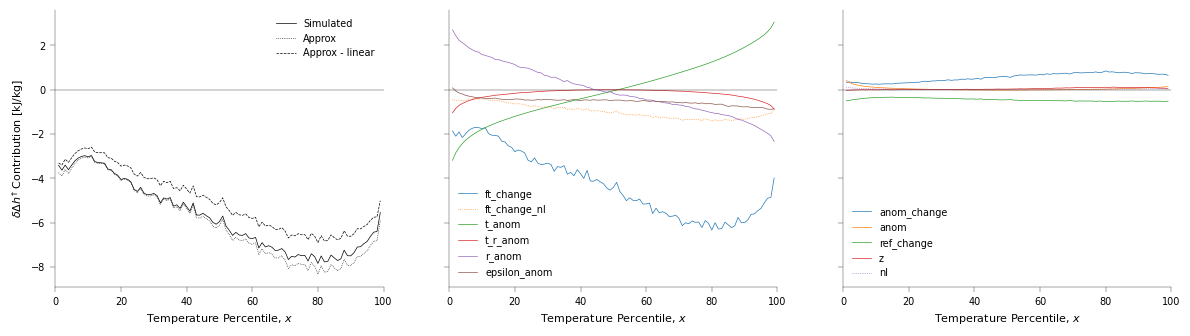

In [51]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
# ax[0].plot(quant_plot, np.average(np.sum(np.array(list(mse_mod_anom_change_cont.values())), axis=0), axis=0, weights=lat_weights)/1000,
#            color='k', linestyle=':')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_ft_change_cont[key] for key in mse_mod_anom_ft_change_cont if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_ft_change_cont[key] for key in mse_mod_anom_ft_change_cont if
                                                   ('approx' not in key) and ('nl' not in key)]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='Approx - linear')
for key in mse_mod_anom_ft_change_cont:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
# ax[1].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
# ax[1].axhline(0, color='k', lw=ax_linewidth)
# ax[0].set_ylabel('$\Delta A_{s\Delta}$ [kJ/kg]')
# ax[1].set_ylabel('$\delta \Delta A_{s\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')
# if show_plot:
#     plt.show()
# else:
#     plt.close()

## Approximations associated with Surface Derivation of $\delta \Delta h^{\dagger}$
Taking the change with warming of $(S1)$, we get (using $\delta (\tilde{\mu}\tilde{\beta}_{s1}) = \delta \tilde{\beta}_{s1}$):

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s}
+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \delta \tilde{\beta}_{s1}
+ (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\right]\delta \Delta T_s[x] \\
&+ \left[L_v\tilde{q}_s + \delta(L_v \tilde{q}_s) + (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\Delta T_s[x]\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
 &+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] \delta \tilde{\beta}_{s1} + \frac{\Delta r_s[x]}{\tilde{r}_s} \delta(L_v \tilde{q}_s)
 - \delta \Delta \epsilon[x] + \delta A_{s\Delta}[x]
 \end{align}\tag{6}$$

We can replace $\delta (L_v \tilde{q}_s)$ using the definition for $\tilde{h}^{\dagger}$, and then using $(S2)$, as well as noting $\tilde{\mu}\tilde{\beta}_{s1} = L_v\tilde{\alpha}_s \tilde{q}_s = \tilde{\beta}_{s1} - (c_p-R^{\dagger})\tilde{T}_s$:

$$\delta (L_v \tilde{q}_s) = \delta \left(\tilde{h}^{\dagger} + \tilde{\epsilon} - (c_p-R^{\dagger})\tilde{T}_s\right)
= \tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)\delta \tilde{T}_s
+ L_v\tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{A}_{s\delta}\tag{7}$$

In [52]:
# Sanity check that equation 7 is correct
# beta_s1[0] - (c_p-R_mod) - mu[0] * beta_s1[0]
sphum_ref_change_eqn = mu[0] * beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() + \
                       L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0] + approx['s_change']
sphum_ref_change_eqn = sphum_ref_change_eqn / L_v
print(sphum_ref_change_eqn - np.diff(sphum_ref, axis=0).squeeze())

[-2.77555756e-17  2.60208521e-18 -1.73472348e-17  8.67361738e-19
  6.93889390e-18  9.97465999e-18  1.64798730e-17 -4.33680869e-18
  1.21430643e-17  4.77048956e-18  8.67361738e-19 -1.04083409e-17
 -6.07153217e-18  2.16840434e-17]


### Approx S3 - Due to non-linear changes with warming
Now lets combine all terms with non-linear changes. We decide that a non-linear term is one with at least 4 combined $\delta$ and $\Delta$ symbols e.g.  $\delta \Delta \chi_1\delta \tilde{\chi}_2 \delta \tilde{\chi}_3$ or $\delta \Delta \chi_1\delta \Delta \chi_2$. We do this as both $\delta$ and $\Delta$ should be small, so when this many multiplied together, should be very small indeed.

$$A_{NL2}[x] = \frac{\Delta r_s[x]}{\tilde{r}_s} \delta \tilde{\beta}_{s1}\delta \Delta T_s[x]
+ \left[\tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s}\delta\tilde{T}_s + \Delta T_s[x] \delta \tilde{\beta}_{s1}
\right]\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)
+ (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) \delta \Delta T_s[x] \tag{S3}$$

Combining $(6)$, $(7)$ and $(S3)$, we get:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s}
+ \delta \tilde{\beta}_{s1}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] \delta \tilde{\beta}_{s1}
+ \tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right) \frac{\Delta r_s[x]}{\tilde{r}_s} \delta \tilde{T}_s
+ L_v\tilde{q}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \frac{\delta \tilde{r}_s}{\tilde{r}_s}
- \delta \Delta \epsilon[x] \\
&+ \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ A_{NL2}[x] + \delta A_{s\Delta}[x]
 \end{align}\tag{8}$$

In [53]:
# approx['s_temp_nl'] = ((1+r_anom[0]/r_ref[0, :, np.newaxis]) * np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] +
#                        (mu[0]*beta_s1[0] + np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze())
# approx['s_temp_nl'] *= np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
#
# approx['s_r_nl'] = (L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0] +
#                     mu[0]*beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) *
#                     np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] + \
#                    np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * temp_anom[0, ind_surf]
# approx['s_r_nl'] *= np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()

approx['s_nl_temp_cont'] = r_anom[0]/r_ref[0, :, np.newaxis] * np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * \
                           np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
approx['s_nl_r_cont'] = (mu[0]*beta_s1[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] \
                        * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()
approx['s_nl_r_cont'] += np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * temp_anom[0, ind_surf] * \
                         np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()
approx['s_nl_temp_r_cont'] = (mu[0]*beta_s1[0] + np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * \
                             np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze() * np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
approx['s_nl'] = approx['s_nl_temp_cont'] + approx['s_nl_r_cont'] + approx['s_nl_temp_r_cont']

In [54]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
# ax.plot(quant_plot, np.average(approx['s_temp_nl'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
# ax.plot(quant_plot, np.average(approx['s_r_nl'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
ax.plot(quant_plot, np.average(approx['s_nl'], axis=0, weights=lat_weights)/1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(approx['s_nl_temp_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='$\delta \Delta T_s$')
ax.plot(quant_plot, np.average(approx['s_nl_r_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='$\delta \Delta r_s$')
ax.plot(quant_plot, np.average(approx['s_nl_temp_r_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle='-.',
        label='$\delta \Delta T_s \delta \Delta r_s$')
# ax.plot(quant_plot, np.average(approx['s_nl3'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\Delta A_{sNL}$ [kJ/kg]')
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature Percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

### Approx S4 - Due to change in $\tilde{\beta}_{s1}$, $\tilde{A}_{s\beta}$
In an analagous way to $(FT2)$, we can do a linear taylor expansion of $\delta \tilde{\beta}_{s1}$:

$$\delta \tilde{\beta}_{s1} = \tilde{\beta}_{s2}(1 + \tilde{A}_{s\beta}) \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s} \tag{S4}$$

where $\beta_{s2} = T_s \frac{\partial^2h^{\dagger}}{\partial T_s^2} =  T_s\frac{\partial \beta_{s1}}{\partial T_s} =
T_s\frac{\partial (\mu \beta_{s1})}{\partial T_s} = L_v \alpha_s q_s(\alpha_s T_s - 2)$. Again, $\tilde{A}_{s\beta}$ quantifies how accurate this linear approximation is, and it arises due to the non-linear temperature dependence of $q^*$. It is dimensionless. Combining this with $(8)$, we get:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \left(\frac{\Delta r_s[x]}{\tilde{r}_s}
+ \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left[\tilde{\beta}_{s2} \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)
+ \tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \right] \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}
+ \left[\tilde{\mu}\tilde{\beta}_{s1} \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s} \right)
+ L_v \tilde{q}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \right]\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \Delta \epsilon[x] \\
&+ \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ A_{NL2}[x] + \delta A_{s\Delta}[x]
+ \left[ \delta \Delta T_s[x]
+ \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \right]\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} \tilde{\beta}_{s2} \tilde{A}_{s\beta}
\end{align}\tag{9}$$

Or re-writing, grouping together $\Delta T_s[x]$ and $\Delta r_s[x]$ terms:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \left(\frac{\Delta r_s[x]}{\tilde{r}_s}
+ \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left[\tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ \tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}  \right]
\left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s} \right)\frac{\Delta T_s[x]}{\tilde{T_s}}
+ \left[\tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta r_s[x]}{\tilde{r}_s}\\
&+ \tilde{A}_{s\delta}'[x] + \delta A_{s\Delta}[x] + A_{NL2}[x]
\end{align}\tag{10}$$

where we have combined approximations due to changes in the reference day:

$$
\tilde{A}_{s\delta}'[x] = \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ \left[ \delta \Delta T_s[x] + \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \right]
\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \frac{\delta \tilde{T}_s}{\tilde{T}_s} \tilde{\beta}_{s2} \tilde{A}_{s\beta}
$$

In [55]:
approx['s_beta'] = (np.diff(beta_s1, axis=0).squeeze() - mu[0] * beta_s1[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0]) \
                   * temp_ref[0, ind_surf] / np.diff(temp_ref[:, ind_surf],axis=0).squeeze() / (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) \
                   /beta_s2[0] - 1
print('A_s_beta = {:.3g}'.format(np.average(approx['s_beta'], axis=0, weights=lat_weights)))

A_s_beta = 0.171


In [56]:
mse_mod_anom_s_change_cont = {
    't_change': beta_s1[0][:, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    't_change_nl_anom': (mu[0] * beta_s1[0])[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    't_change_nl_change': (mu[0] * beta_s1[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0])
                          + beta_s2[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() / temp_ref[0, ind_surf] *
                             (1 + (np.diff(r_ref, axis=0).squeeze()/r_ref[0])))[:, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    'r_change': L_v * sphum_ref[0, :, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(),
    'r_change_nl_anom': (mu[0] * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(),
    'r_change_nl_change': (mu[0] * beta_s1[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() +
                           L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0])[:, np.newaxis] *
                          np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(),
    't_anom': (beta_s2[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf]
              + mu[0] * beta_s1[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0])[:, np.newaxis] * temp_anom[0, ind_surf],
    'r_anom': (mu[0] * beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()
              + L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0])[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis],
    'epsilon_change': -np.diff(epsilon_anom, axis=0).squeeze()
}
mse_mod_anom_s_change_cont['t_r_anom'] = mse_mod_anom_s_change_cont['t_anom'] * r_anom[0] / r_ref[0, :, np.newaxis]

# Approx terms
# Contribution to ref change error from change A_{s\delta}
mse_mod_anom_s_change_cont['approx_ref_change'] = approx['s_change'][:, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis] +
                                                                                       np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze())
# Contribution to ref change error from change in beta
mse_mod_anom_s_change_cont['approx_ref_change'] += (beta_s2[0] * approx['s_beta'] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) *
                                             np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf])[:, np.newaxis] *  \
                                            (np.diff(temp_anom[:, ind_surf], axis=0).squeeze() + temp_anom[0, ind_surf] *
                                             (1 + r_anom[0]/r_ref[0, :, np.newaxis]))
mse_mod_anom_s_change_cont['approx_nl'] = approx['s_nl']
mse_mod_anom_s_change_cont['approx_anom_change'] = np.diff(approx['s_anom'], axis=0).squeeze()


In [57]:
# Sanity check that sum of all terms is equal to actual MSE mod anom change
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_s_change_cont.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 4.7e-11


Text(0, 0.5, '$\\delta \\Delta h^{\\dagger}$ Contribution [kJ/kg]')

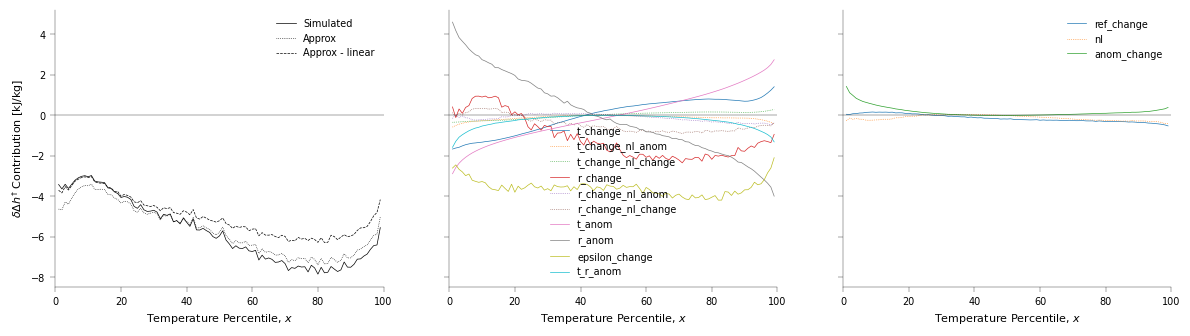

In [58]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_s_change_cont[key] for key in mse_mod_anom_s_change_cont if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_s_change_cont[key] for key in mse_mod_anom_s_change_cont if
                                                   ('approx' not in key) and ('nl' not in key)]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='Approx - linear')
for key in mse_mod_anom_s_change_cont:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_s_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_s_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
# ax[2].plot(quant_plot, np.average(mse_mod_anom_s_change_cont['approx_beta'] + mse_mod_anom_s_change_cont['approx_ref_change'],
#                                   axis=0, weights=lat_weights) / 1000)
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
# ax[1].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
# ax[1].axhline(0, color='k', lw=ax_linewidth)
# ax[0].set_ylabel('$\Delta A_{s\Delta}$ [kJ/kg]')
# ax[1].set_ylabel('$\delta \Delta A_{s\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')
# if show_plot:
#     plt.show()
# else:
#     plt.close()

## Equation for $\delta \Delta T_s(x)$
Equating our two equations for $\delta \Delta h^{\dagger}[x]$, we can get an equation for $\delta \Delta T_s(x)$:

$$\begin{align}
\tilde{\beta}_{s1}\left(1 + \tilde{\mu} \frac{\Delta r_s[x]}{\tilde{r}_s} \right) \delta \Delta T_s(x) =
&-\left[\tilde{\mu} \frac{\delta \tilde{r}_s}{\tilde{r}_s} +
\frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]
\tilde{\beta}_{s1} \delta \Delta T_s[x] + \left(1 + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right) \tilde{\beta}_{FT1} \delta \Delta T_{FT}[x] \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\tilde{\mu}\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \delta \tilde{h}^{\dagger}_0
- \tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
- L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right] \frac{\Delta r_s[x]}{\tilde{r_s}} \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
- \tilde{A}_{s\delta}'[x] - \delta A_{s\Delta}[x] - A_{NL2}[x]
\end{align}\tag{11}$$

### Approx NL3 - Assume $\delta \tilde{\chi}\delta \Delta T_s[x]$ and $\delta \tilde{\chi}\delta \Delta T_{FT}[x]$ terms cancel
Separating the first line of the RHS of $(11)$ into $\delta T[x]$ and $\delta \tilde{T}$ terms, and noting from $(FT3)$ that
$\delta \tilde{T}_{FT} = \frac{\delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} -
\delta \tilde{A}_{z}}{\tilde{\beta}_{FT1}}$, we get:



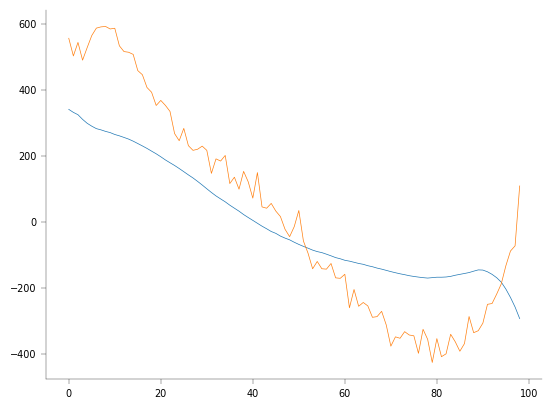

In [63]:
plt.plot(-np.average(mse_mod_anom_s_change_cont['t_change_nl_change'], axis=0, weights=lat_weights))
plt.plot(np.average(mse_mod_anom_ft_change_cont['ft_change_nl'], axis=0, weights=lat_weights)+1000)